https://raphaellederman.github.io/articles/musicgeneration/#training-the-language-model

http://deeplearning.net/tutorial/rnnrbm.html

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from music21 import converter, instrument, note, chord, stream
from keras.layers import Input, Dense, Reshape, Dropout, Bidirectional, LSTM
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils

import pretty_midi
from scipy.io import wavfile 
import IPython



import matplotlib.pyplot as plt
import numpy as np
import glob

Using TensorFlow backend.


In [2]:

n_x = 79
max_T_x = 1000
sequence_length = 100
y_generated = 10

In [3]:
def get_notes():
    """ Get all the notes and chords from the midi files """
    notes = []

    for file in glob.glob("data/*.mid"):
        midi_data = pretty_midi.PrettyMIDI(file)
        print("Parsing %s" % file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        # convert to one-hot-encoding
        T_x = len(note_l)
        print (T_x)
        if T_x > max_T_x:
            T_x = max_T_x
        X_ohe = np.zeros((T_x, n_x))
        for t in range(T_x): 
             X_ohe[t, note_l[t]-1] = 1
        # add to the list  
        notes.append(X_ohe)
    return notes

In [4]:
def prepare_sequences(notes, n_vocab):
    sequence_length = 100
    network_input = []
    network_output = []

  
    network_input = [notes[i][t:t+sequence_length] for i in range(len(notes)) 
                     for t in range(len(notes[i])-sequence_length)]
    
    network_output = [notes[i][t+ sequence_length] for i in range(len(notes)) 
                      for t in range(len(notes[i])-sequence_length)]

    sequence_in = np.asarray(network_input)
    sequence_out = np.asarray(network_output)

    print("X_train.shape:", sequence_in.shape)
    print("y_train.shape:", sequence_out.shape)
    return (sequence_in, sequence_out)

In [5]:
notes = get_notes()
n_vocab = len(notes)
network_input,network_output = prepare_sequences(notes, n_vocab)
#print (network_input,network_output )

Parsing data/rock.mid
969
Parsing data/rock1.mid
18
X_train.shape: (869, 100, 79)
y_train.shape: (869, 79)


/home/bikash/anaconda3/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [6]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 79)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        

    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(100, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        notes = get_notes()
        vocab = len(notes)
        X_train, y_train = prepare_sequences(notes,vocab)

        # Adversarial ground truths
        real = np.ones((batch_size, 100))
        fake = np.zeros((batch_size, 100))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]
            print (real_seqs.shape, real.shape)
            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 100, (batch_size, self.latent_dim))
            
            # Generate a batch of new note sequences
            
            gen_seqs = self.generator.predict(noise)
            

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        #print (notes)
        #self.generate(notes)
        self.plot_loss()
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

In [7]:
gan = GAN(rows=100)    
gan.train(epochs=15, batch_size=10, sample_interval=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1212416   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_______________________________________

/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.692895, acc.: 49.35%] [G loss: 0.693333]
(10, 100, 79) (10, 100)


/home/bikash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.686261, acc.: 71.50%] [G loss: 0.693544]
(10, 100, 79) (10, 100)
2 [D loss: 0.677195, acc.: 79.40%] [G loss: 0.693730]
(10, 100, 79) (10, 100)
3 [D loss: 0.659133, acc.: 83.45%] [G loss: 0.694655]
(10, 100, 79) (10, 100)
4 [D loss: 0.624078, acc.: 85.65%] [G loss: 0.696196]
(10, 100, 79) (10, 100)
5 [D loss: 0.470288, acc.: 89.50%] [G loss: 1.291401]
(10, 100, 79) (10, 100)
6 [D loss: 0.238025, acc.: 93.25%] [G loss: 1.456306]
(10, 100, 79) (10, 100)
7 [D loss: 0.116564, acc.: 98.00%] [G loss: 2.035398]
(10, 100, 79) (10, 100)
8 [D loss: 0.052145, acc.: 100.00%] [G loss: 1.922152]
(10, 100, 79) (10, 100)
9 [D loss: 0.023820, acc.: 100.00%] [G loss: 2.160273]
(10, 100, 79) (10, 100)
10 [D loss: 0.012863, acc.: 100.00%] [G loss: 3.470809]
(10, 100, 79) (10, 100)
11 [D loss: 0.008327, acc.: 100.00%] [G loss: 2.454070]
(10, 100, 79) (10, 100)
12 [D loss: 0.005845, acc.: 100.00%] [G loss: 3.210561]
(10, 100, 79) (10, 100)
13 [D loss: 0.004482, acc.: 100.00%] [G loss: 3.352061]


In [8]:
notes = get_notes()
n_vocab = len(notes)
X_train_list,Y_train_list = prepare_sequences(notes, n_vocab)

Parsing data/rock.mid
969
Parsing data/rock1.mid
18
X_train.shape: (869, 100, 79)
y_train.shape: (869, 79)


/home/bikash/anaconda3/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [22]:
# Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

def generate(input_notes, model):
    # Get pitch names and store in a dictionary
    notes = input_notes
    # Use random noise to generate sequences
    noise = np.random.normal(0, 100, (1, model.latent_dim))

    predictions = model.generator.predict(noise)
    #print (predictions)
    return predictions
    
predictions = generate(notes, gan)
print (predictions.shape)
#print (predictions[0])
note = np.argmax(predictions[0], axis=1)
print (note)
note = [int(x) for x in note] 
note_ohe = np.zeros(79)
note_ohe[note] = 1
pattern = np.vstack((pattern, note_ohe))

125
(100, 79)
(1, 100, 79)
(1, 100, 79)
[0 1 0 1 4 1 1 2 1 0 0 0 5 0 5 1 0 0 3 8 0 1 1 1 2 0 1 0 2 0 0 0 2 0 1 0 3
 4 5 2 0 0 0 2 0 0 2 0 1 1 0 1 1 0 1 3 0 0 1 0 0 1 4 0 1 0 0 0 2 1 7 1 5 5
 1 1 1 4 0 0 1 0 0 6 2 2 1 0 1 2 1 0 1 0 4 2 0 2 0 3]


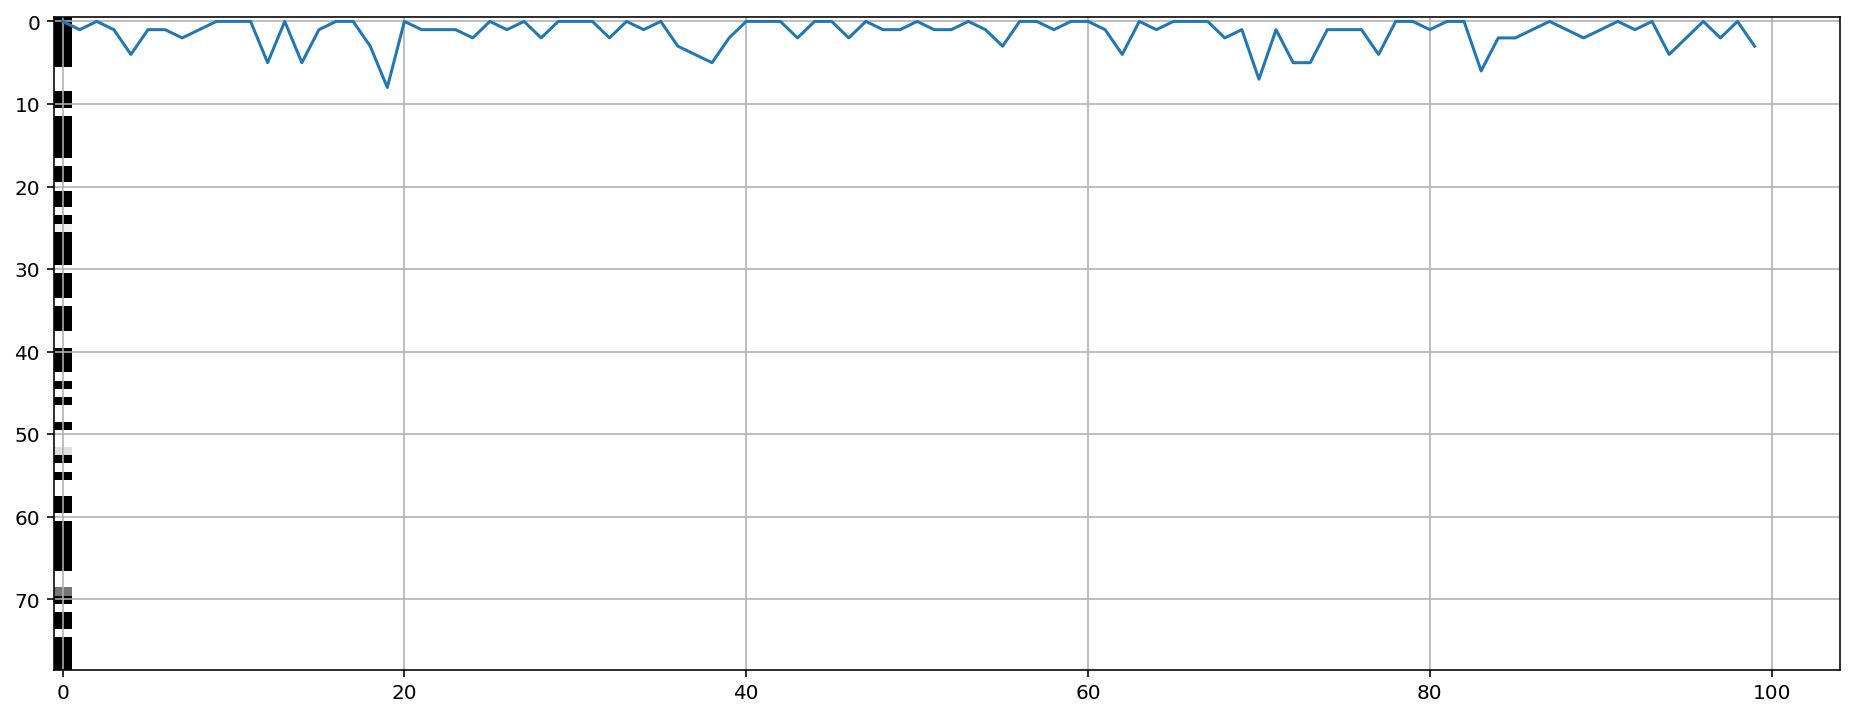

In [23]:
plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(predictions)[:,0,:].T, aspect='auto')
plt.plot(note)
plt.set_cmap('gray_r')
plt.grid(True)

In [28]:
def create_midi(notes):
    new_midi_data = pretty_midi.PrettyMIDI()
    drum_program = pretty_midi.instrument_name_to_program('SteelDrums')
    drum = pretty_midi.Instrument(program=drum_program)
    time = 0
    step = 0.1
    for note_number in notes[0]:
        print (note_number)
        for note1 in note_number:
            myNote = pretty_midi.Note(velocity=60, pitch=int(note1), start=time, end=time+step)
            drum.notes.append(myNote)
            time += step
    new_midi_data.instruments.append(drum)
    return new_midi_data

new_midi_data = create_midi(notes)
print (new_midi_data)
new_midi_data.write('final.mid')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0.